In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')

env.call('../002_design_optics/matching_constraints.py')

In [4]:
line = -env['ccs_yl']

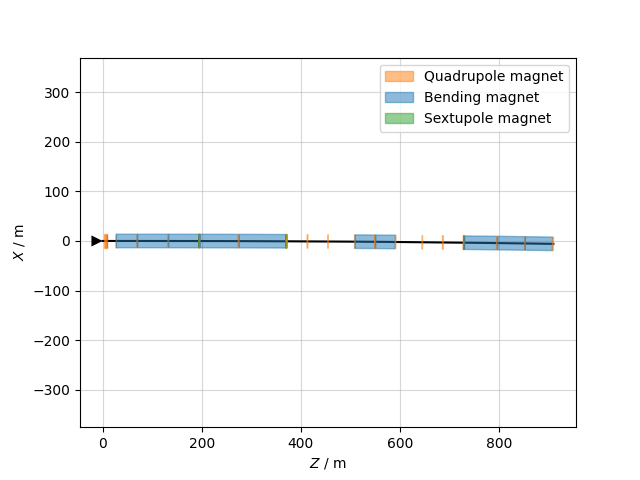

In [5]:
line.survey().plot()

In [6]:
kq_doublet = ['kqd0al', 'kqd0bl', 'kqf1al']
kq_section_a = ['kqd01l', 'kqf02l', 'kqd02l']
kq_section_b = ['kqd04l', 'kqf05l', 'kqd06l']
kq_yquads = ['kqy01l', 'kqy02l', 'kqy03l', 'kqy04l']

In [7]:
# Initialize quadrupoles with a small strength
for nn in kq_doublet + kq_section_a + kq_section_b +kq_yquads:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

In [8]:
opt_doublet = line.match(
    name='doublet',
    solve=False,
    betx=env['bxip'],
    bety=env['byip'],
    default_tol=1e-5,
    targets=[
        # Peak in the doublet
        xt.TargetSet(bety=xt.LessThan(8550), at='qd0bl'),
        # Doublet exit
        xt.TargetSet(bety=xt.LessThan(3500), at='qf1bl'),
        xt.TargetSet(bety=xt.GreaterThan(3300), at='qf1bl'),
        # First quadrupole downstream
        xt.TargetSet(betx=xt.GreaterThan(1300), at='qd1l'),
        xt.TargetSet(betx=xt.LessThan(1400), at='qd1l'),
        xt.TargetSet(bety=xt.LessThan(3200), at='qd1l'),
        xt.TargetSet(bety=xt.GreaterThan(3100), at='qd1l'),
    ],
    vary = xt.VaryList(kq_doublet, step=1e-8)
)
opt = opt_doublet
opt.step(100)

                                             
Optimize [doublet] - start penalty: 1.004e+06
Matching: model call n. 45               
Optimize [doublet] - end penalty:     0


(<xtrack.twissplot.TwissPlot object at 0x15c266790>,
 <xtrack.twissplot.TwissPlot object at 0x15c266790>)

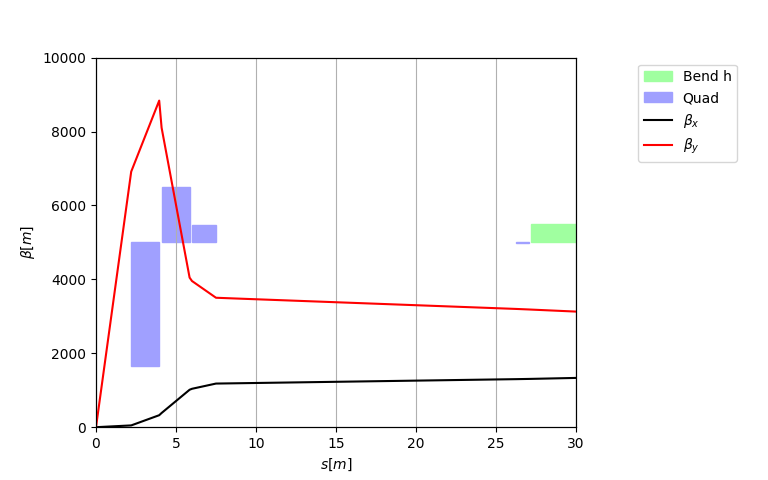

In [9]:
pp=opt.plot('betx bety')
pp.xlim(0, 30), pp.ylim(left_lo=0, left_hi=10000)

### Match section A (up to the first sextupole - sdm1l)

In [10]:
opt_sdm1l = opt_doublet.clone(
    name='sdm1l',
    remove_vary=True, remove_targets=True,
    add_targets=[
        xt.TargetSet(betx=xt.LessThan(10.), bety=xt.LessThan(12.),
                         alfx=xt.GreaterThan(-1.), alfy=0.0,
                         at='sdm1l::0'),
        xt.TargetSet(betx=xt.LessThan(3000), at='qf2l'),
        xt.TargetSet(bety=xt.GreaterThan(900), at='qf2l'),
    ], 
    add_vary=xt.VaryList(kq_section_a, step=1e-8),
)
opt = opt_sdm1l
opt.step(100)

                                             
Optimize [sdm1l] - start penalty: 3079  
Matching: model call n. 738               
Optimize [sdm1l] - end penalty:  0.628937


In [11]:
opt.target_status()

Target status:                            
id state tag           tol_met       residue   current_val target_val       description                                 
0  ON    sdm1l::0_betx   False     -0.628852       10.6289 LessThan(10)     ('betx', 'sdm1l::0'), val=LessThan(10),  ...
1  ON    sdm1l::0_bety    True             0       6.50544 LessThan(12)     ('bety', 'sdm1l::0'), val=LessThan(12),  ...
2  ON    sdm1l::0_alfx    True             0    -0.0952339 GreaterThan(-1)  ('alfx', 'sdm1l::0'), val=GreaterThan(-1 ...
3  ON    sdm1l::0_alfy   False  -0.000800418  -0.000800418 0.0              ('alfy', 'sdm1l::0'), val=0, tol=1e-05,  ...
4  ON    qf2l_betx        True             0       2824.21 LessThan(3000)   ('betx', 'qf2l'), val=LessThan(3000), to ...
5  ON    qf2l_bety       False   -0.00650626       899.993 GreaterThan(900) ('bety', 'qf2l'), val=GreaterThan(900),  ...


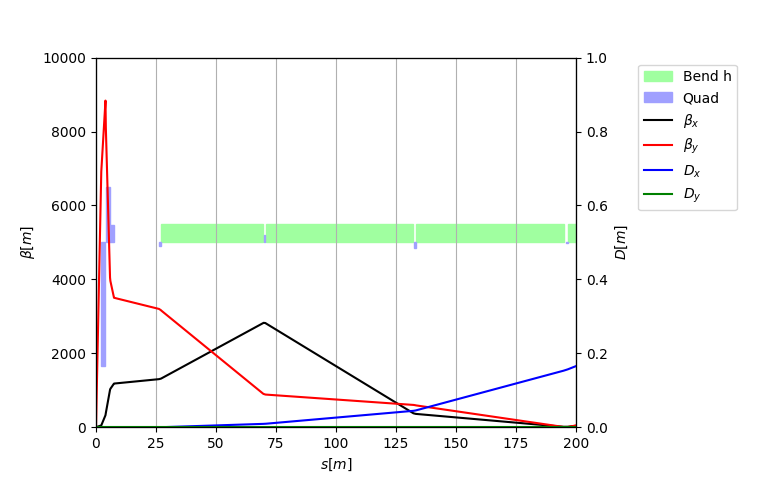

In [12]:
pp=opt.plot()
pp.xlim(0, 200); pp.ylim(0, 1e4, 0, 1)

### Match section B (up to second sextupole `sdy1l::1`)

In [13]:
# First we use only quadrupoles in section B
opt_sdy1l = opt_sdm1l.clone(
    name='sdy1l', 
    remove_targets=True, remove_vary=True,
    add_targets=xt.TargetSet(at='sdy1l::1',
        bety=8114.3, betx=371.7,
        alfy=0., dx=xt.GreaterThan(0.3),
        muy=0.75 + env['dmuy_sdy1l']),
    add_vary=xt.VaryList(kq_section_b, step=1e-8))
opt = opt_sdy1l
opt.step(100)

                                             
Optimize [sdy1l] - start penalty: 3493  
Matching: model call n. 695               
Optimize [sdy1l] - end penalty:  1005.78


In [14]:
# Then we use also the quadrupoles in section A
opt_sdy1l_refine = opt_sdy1l.clone(name='dsdy1l_refine',
                    add_vary=xt.VaryList(kq_section_a, step=1e-8),
                    add_targets=opt_sdm1l.targets)
opt = opt_sdy1l_refine

In [15]:
opt.step(50)

                                             
Optimize [dsdy1l_refine] - start penalty: 1006
Matching: model call n. 560               
Optimize [dsdy1l_refine] - end penalty:  48.9871


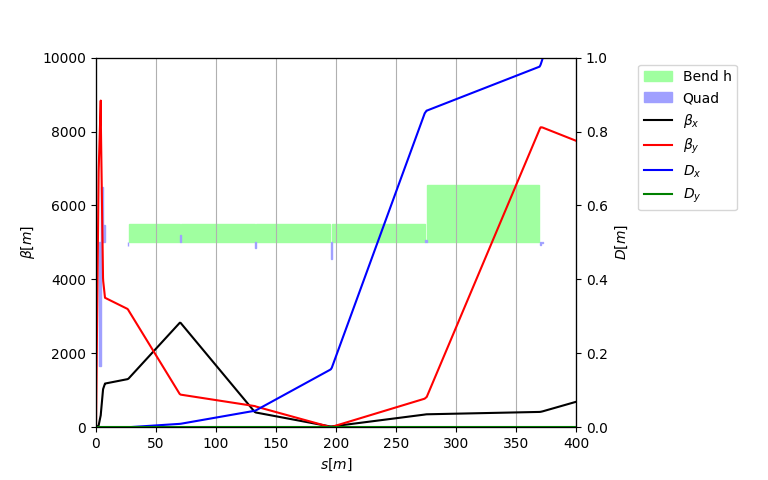

In [16]:
pp = opt.plot()
pp.xlim(0, 400); pp.ylim(0, 1e4, 0, 1)

### Create a -I transformation between `sdy1l` and `sdy2l`

In [17]:
opt_rsext = line.match(
    name='rmat_sext',
    solve=False,
    start='sdy1l::1', end='sdy2l::1', init_at='ipimag2',
    betx=135, bety=10, # Rough estimate
    targets=xt.TargetRmatrix(start='sdy1l::1', end='sdy2l::1',
                r12=env['r12_ccsyl'], r34=env['r34_ccsyl'],
                r33=-1.0, r43=0.0, 
                tol=1e-6, tag='rmat_sext'),
    vary=xt.VaryList(kq_yquads, step=1e-8)
)

opt = opt_rsext
opt.disable(target=True)
opt.enable(target=0)
opt.step(20)
opt.enable(target=1)
opt.step(20)
opt.enable(target=2)
opt.step(20)
opt.enable(target=3)
opt.step(20)

                                             
Optimize [rmat_sext] - start penalty: 346.7
Matching: model call n. 31               
Optimize [rmat_sext] - end penalty:  1.08275e-06
                                             
Optimize [rmat_sext] - start penalty: 8.871
Matching: model call n. 69               
Optimize [rmat_sext] - end penalty:  7.2164e-07
                                             
Optimize [rmat_sext] - start penalty: 436.8
Matching: model call n. 113               
Optimize [rmat_sext] - end penalty:  7.2606e-06
                                             
Optimize [rmat_sext] - start penalty: 7.281e-06
Matching: model call n. 120               
Optimize [rmat_sext] - end penalty:  2.00327e-09


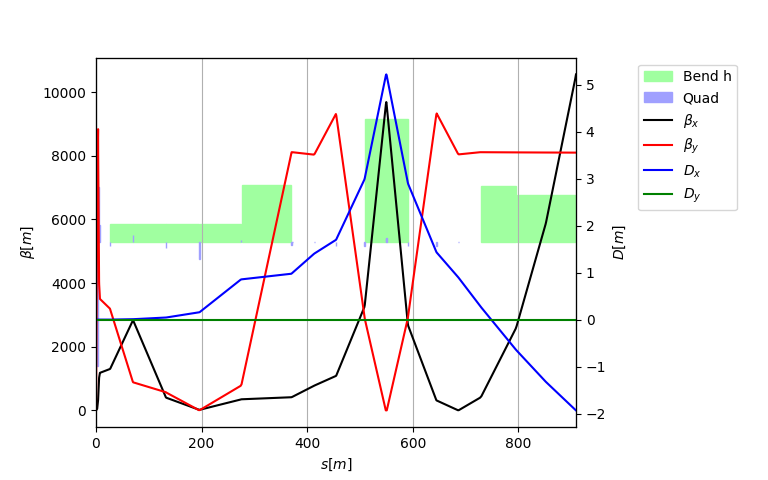

In [18]:
opt_sdy1l.plot()

### Control beta end dispersion at IP image point
(preserving all conditions matched so far)

In [19]:
opt_imag2 = line.match(
    solve=False,
    name='imag2',
    betx=env['bxip'],
    bety=env['byip'],
    default_tol=1e-5,
    vary=[
        xt.VaryList(kq_section_a, tag='section_a', step=1e-8),
        xt.VaryList(kq_section_b, tag='section_b', step=1e-8),
        xt.VaryList(kq_yquads, tag='section_y', step=1e-8)],
    targets=list(opt_sdm1l.targets['sdm1l.*'])
          + list(opt_sdy1l.targets)
          + list(opt_rsext.targets) 
          + [xt.TargetSet(at='ipimag2',
                betx=xt.GreaterThan(60.),
                alfx=0., alfy=0.,
                dx=0.302, dpx=0)]
)
opt = opt_imag2

In [20]:
opt_imag2.target_status()

Target status:                          
id state tag           tol_met       residue   current_val target_val       description                                 
0  ON    sdm1l::0_betx   False      -12.1001       22.1001 LessThan(10)     ('betx', 'sdm1l::0'), val=LessThan(10),  ...
1  ON    sdm1l::0_bety    True             0       8.51339 LessThan(12)     ('bety', 'sdm1l::0'), val=LessThan(12),  ...
2  ON    sdm1l::0_alfx    True             0      0.785726 GreaterThan(-1)  ('alfx', 'sdm1l::0'), val=GreaterThan(-1 ...
3  ON    sdm1l::0_alfy   False      -0.64058      -0.64058 0.0              ('alfy', 'sdm1l::0'), val=0, tol=1e-05,  ...
4  ON    sdy1l::1_betx   False       46.9506       418.651 371.7            ('betx', 'sdy1l::1'), val=371.7, tol=1e- ...
5  ON    sdy1l::1_bety   False      -1.44127       8112.86 8114.3           ('bety', 'sdy1l::1'), val=8114.3, tol=1e ...
6  ON    sdy1l::1_alfy   False     0.0473481     0.0473481 0.0              ('alfy', 'sdy1l::1'), val=0, tol=1e-

In [21]:
opt.step(100)

                                             
Optimize [imag2] - start penalty: 94.37 
Matching: model call n. 385               
Optimize [imag2] - end penalty:  0.000118679


In [22]:
opt.target_status()

Target status:                            
id state tag           tol_met       residue   current_val target_val       description                                 
0  ON    sdm1l::0_betx    True             0       8.43103 LessThan(10)     ('betx', 'sdm1l::0'), val=LessThan(10),  ...
1  ON    sdm1l::0_bety    True             0       10.5617 LessThan(12)     ('bety', 'sdm1l::0'), val=LessThan(12),  ...
2  ON    sdm1l::0_alfx    True             0    -0.0585172 GreaterThan(-1)  ('alfx', 'sdm1l::0'), val=GreaterThan(-1 ...
3  ON    sdm1l::0_alfy    True  -5.56035e-09  -5.56035e-09 0.0              ('alfy', 'sdm1l::0'), val=0, tol=1e-05,  ...
4  ON    sdy1l::1_betx    True   4.75731e-06         371.7 371.7            ('betx', 'sdy1l::1'), val=371.7, tol=1e- ...
5  ON    sdy1l::1_bety    True   8.16974e-06        8114.3 8114.3           ('bety', 'sdy1l::1'), val=8114.3, tol=1e ...
6  ON    sdy1l::1_alfy    True   1.28114e-09   1.28114e-09 0.0              ('alfy', 'sdy1l::1'), val=0, tol=1

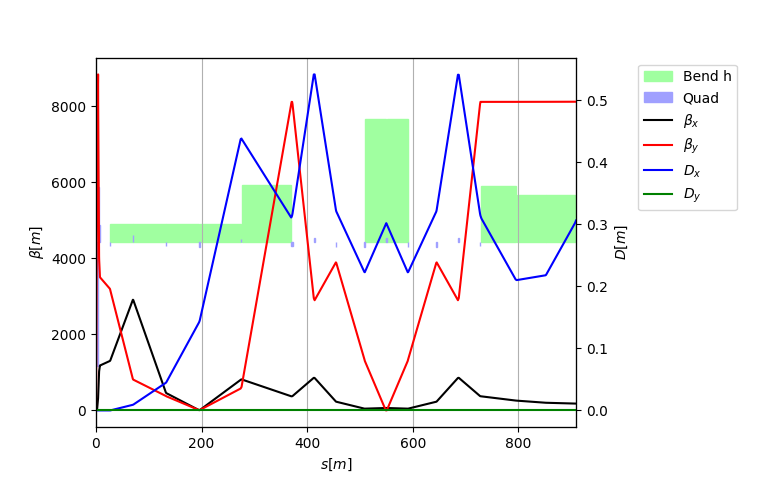

In [23]:
opt.plot()

In [24]:
tt_vars = line.vars.get_table()
tt_out = tt_vars.rows[kq_doublet + kq_section_a + kq_section_b + kq_yquads]
strengths = tt_out.to_dict()

In [25]:
strengths

{'kqd0al': -0.37492025431000975,
 'kqd0bl': 0.16872137361862974,
 'kqf1al': 0.051973132863475366,
 'kqd01l': -0.011158765296559707,
 'kqf02l': 0.021668458001773323,
 'kqd02l': -0.010378211967662093,
 'kqd04l': -0.0132062547756468,
 'kqf05l': 0.009907340740689687,
 'kqd06l': -0.009589913362132827,
 'kqy01l': -0.012214333702330637,
 'kqy02l': 0.012644389794187652,
 'kqy03l': -0.01390444375232805,
 'kqy04l': 0.013479771541488371}

In [26]:
xt.json.dump(strengths, 'strengths_quads_01_ffccsyl.json')